In [40]:
import numpy as np 
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

In [41]:
class CNN(nn.Module):

    def __init__(self, n_channels, n_hidden, output_size=1, kernel_size=3):
        super(CNN, self).__init__()
        setattr(self, 'conv1', nn.Conv1d(n_channels, n_hidden, kernel_size, padding=1))
        setattr(self, 'fc1', nn.Linear(24 * n_hidden, output_size))

    def forward(self, x):
        x = getattr(self, 'conv1')(x)
        x = F.relu(x)
        x = F.max_pool1d(x, 2)
        x = x.view(-1, self.num_flat_features(x))
        x = getattr(self, 'fc1')(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [42]:
# Get consumption profile in [0,1]
cons_train = np.load("data/example_nondeterminist_cons_train.npy")[0:1*365*24]
cons_val = np.load("data/example_nondeterminist_cons_train.npy")[365*24:2*365*24]
cons_test = np.load("data/example_nondeterminist_cons_test.npy")[0:1*365*24]
# use previous 48 hours to predict
n_train = cons_train.shape[0] - 49
X_train = torch.Tensor([cons_train[i:i+48] for i in range(n_train)]).reshape((n_train, 1, 48))
y_train = torch.Tensor([cons_train[49 + i] for i in range(n_train)]).reshape((n_train, 1))
n_val = cons_val.shape[0] - 49
X_val = torch.Tensor([cons_val[i:i+48] for i in range(n_val)]).reshape((n_val, 1, 48))
y_val = torch.Tensor([cons_val[49 + i] for i in range(n_val)]).reshape((n_val, 1))

In [43]:
class PinballLoss(nn.Module):

    def __init__(self, quantiles):
        super(PinballLoss, self).__init__()
        self.quantiles = torch.Tensor(quantiles).reshape(1, -1)

    def forward(self, y_pred, y_true):
        assert self.quantiles.shape[1] == y_pred.shape[1]
        q = self.quantiles.expand(y_pred.shape[0], -1)
        y_true = y_true.expand(-1, y_pred.shape[1])
        pb = torch.where(
            y_pred >= y_true, 
            (1 - q) * (y_pred - y_true), 
            q * (y_true - y_pred)
        )
        return torch.mean(pb)

In [44]:
quantiles = np.arange(0.1, 1, 0.1).reshape((1, -1))
pb_loss = PinballLoss(quantiles)

cnn = CNN(1, 2, output_size=quantiles.shape[1])
optimizer = optim.SGD(cnn.parameters(), lr=0.01)
batch_size = 32
epoch_losses = []
for i in range(150):
    epoch_loss = 0.
    # in your training loop:
    perm = torch.randperm(n_train)
    X_train = X_train[perm,:,:]
    y_train = y_train[perm]
    for j in range(0, n_train, batch_size):
        if j + batch_size < n_train:
            X = X_train[j:j+batch_size,:,:]
            y = y_train[j:j+batch_size]
        else:
            X = X_train[j:,:,:]
            y = y_train[j:]
        optimizer.zero_grad()   # zero the gradient buffers
        y_pred = cnn(X)
        loss = pb_loss(y_pred, y)
        loss.backward()
        optimizer.step()    # Does the update
        epoch_loss += loss
    epoch_losses.append(epoch_loss)

Text(0, 0.5, 'Pinball Loss')

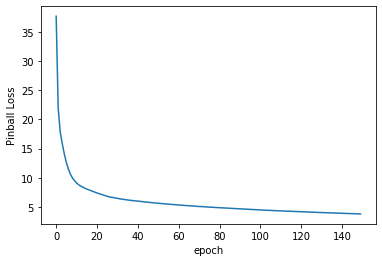

In [45]:
plt.figure()
plt.plot(epoch_losses)
plt.xlabel('epoch')
plt.ylabel('Pinball Loss')

Text(0, 0.5, 'Predicted Median Normalized Consumption')

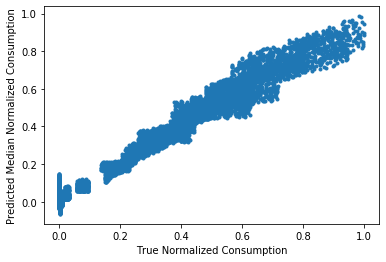

In [48]:
plt.figure()
y_pred = cnn(X_val).detach().numpy()
plt.plot(y_val, y_pred[:,4], '.')
plt.xlabel('True Normalized Consumption')
plt.ylabel('Predicted Median Normalized Consumption')

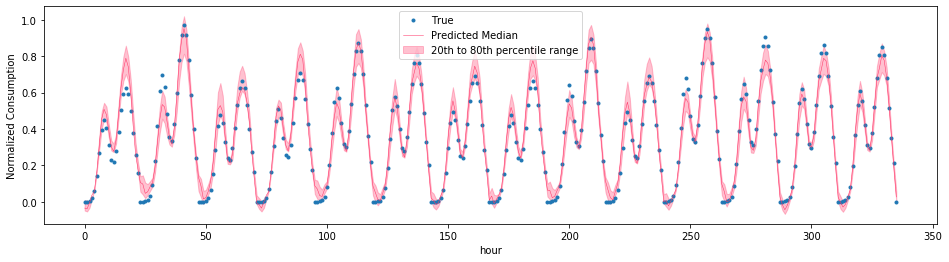

In [49]:
zoom = 24 * 14
x = np.arange(y_val.shape[0])
plt.figure(figsize=(16,4))
plt.plot(x[:zoom], y_val[:zoom], '.', linewidth=0.2, label='True')
plt.fill_between(x[:zoom], y_pred[:zoom,1], y_pred[:zoom,7], alpha=0.3, color='#ff3366', label='20th to 80th percentile range')
plt.plot(x[:zoom], y_pred[:zoom,4], linewidth=0.5, label='Predicted Median', color='#ff3366')
plt.xlabel('hour')
plt.ylabel('Normalized Consumption')
plt.legend()